In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from functools import cached_property
from typing import Optional, Callable
from pydantic import BaseModel, Field, computed_field, ConfigDict
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from mlforecast import MLForecast
from mlforecast.auto import AutoMLForecast, AutoModel # (AutoLightGBM, AutoRidge, )
from mlforecast.lag_transforms import ExponentiallyWeightedMean, RollingMean, RollingStd
from statsforecast.models import Naive, SeasonalNaive, ZeroModel
from statsforecast import StatsForecast
import optuna
import matplotlib.pyplot as plt

In [7]:
1e-5 == 0.00001

True

In [24]:
# df_features = pd.read_csv("../data/features_2011-12-02_2015-12-31.csv", parse_dates=["ds"])
# df_targets = pd.read_csv("../data/target_features_2011-12-02_2015-12-31.csv", parse_dates=["ds"])

In [2]:
df_features = pd.read_csv("../data/processed/features_2012-01-01_2015-12-31.csv", parse_dates=["ds"])
df_targets = pd.read_csv("../data/processed/target_features_2012-01-01_2015-12-31.csv", parse_dates=["ds"])

In [4]:
df_features.select_dtypes(include=[np.number]).columns.tolist()

['wm_yr_wk',
 'wday',
 'month',
 'year',
 'snap_CA',
 'Chanukah End',
 'Christmas',
 'Cinco De Mayo',
 'ColumbusDay',
 'Easter',
 'Eid al-Fitr',
 'EidAlAdha',
 "Father's day",
 'Halloween',
 'IndependenceDay',
 'LaborDay',
 'LentStart',
 'LentWeek2',
 'MartinLutherKingDay',
 'MemorialDay',
 "Mother's day",
 'NBAFinalsEnd',
 'NBAFinalsStart',
 'NewYear',
 'OrthodoxChristmas',
 'OrthodoxEaster',
 'Pesach End',
 'PresidentsDay',
 'Purim End',
 'Ramadan starts',
 'StPatricksDay',
 'SuperBowl',
 'Thanksgiving',
 'ValentinesDay',
 'VeteransDay',
 'sell_price',
 'is_item_exists']

In [3]:
df_targets.head()

,unique_id,ds,y,periods since last sales,periods since last 0 sales
0,CA_1__FOODS_3_001,2011-12-02,0,1,0
1,CA_1__FOODS_3_001,2011-12-03,0,2,0
2,CA_1__FOODS_3_001,2011-12-04,0,3,0
3,CA_1__FOODS_3_001,2011-12-05,2,0,1
4,CA_1__FOODS_3_001,2011-12-06,2,0,2


In [28]:
'_'.join("CA_1__FOODS_3_001".split("_")[-3: -1])

'FOODS_3'

In [22]:
def extract_number(s):
    return s.split("CA_1__FOODS_3_")[-1]

In [24]:
df_features['unique_id'].apply(extract_number).unique()

array(['001', '003', '006', '009', '010', '016', '017', '018', '033',
       '036', '038', '044', '047', '049', '055', '057', '061', '072',
       '084', '085', '110', '114', '119', '122', '125', '137', '143',
       '145', '147', '149', '152', '157', '158', '164', '166', '170',
       '173', '180', '198', '204', '209', '210', '218', '221', '229',
       '240', '244', '247', '254', '260', '262', '268', '270', '275',
       '278', '315', '340', '341', '343', '353', '358', '359', '360',
       '366', '370', '379', '380', '390', '396', '397', '402', '409',
       '414', '416', '417', '419', '421', '425', '426', '427', '430',
       '440', '442', '445', '452', '453', '487', '507', '518', '527',
       '528', '529', '539', '544', '548', '550', '556', '558', '564',
       '576', '597', '600', '602', '605', '613', '619', '626', '633',
       '637', '639', '642', '647', '649', '650', '658', '662', '691',
       '696', '698', '701', '709', '710', '719', '724', '735', '736',
       '743', '745',

In [3]:
features_to_drop = ["wm_yr_wk", "wday", "year",'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
df_features = df_features.drop(columns=features_to_drop)
df_features

,unique_id,ds,weekday,month,snap_CA,Chanukah End,Christmas,Cinco De Mayo,ColumbusDay,Easter,...,PresidentsDay,Purim End,Ramadan starts,StPatricksDay,SuperBowl,Thanksgiving,ValentinesDay,VeteransDay,sell_price,is_item_exists
0,CA_1__FOODS_3_001,2011-12-02,Friday,12,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.50,1
1,CA_1__FOODS_3_001,2011-12-03,Saturday,12,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.50,1
2,CA_1__FOODS_3_001,2011-12-04,Sunday,12,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.50,1
3,CA_1__FOODS_3_001,2011-12-05,Monday,12,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.50,1
4,CA_1__FOODS_3_001,2011-12-06,Tuesday,12,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205753,CA_1__FOODS_3_821,2015-12-27,Sunday,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.98,1
205754,CA_1__FOODS_3_821,2015-12-28,Monday,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.98,1
205755,CA_1__FOODS_3_821,2015-12-29,Tuesday,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.98,1
205756,CA_1__FOODS_3_821,2015-12-30,Wednesday,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.98,1


# Preprocessing:
* one-hot encoder
* standard scaler (per store_id, id)
* weekofyear instead of month
* clip prediction?
* moving average/SD
* train-test split

In [4]:
class FourierModes(BaseEstimator, TransformerMixin):
    def __init__(self, T: float=365.25, k: int=1, time_col: str="day_of_year", drop_time_col: bool=False):
        self.T = T
        self.k = k
        self.time_col = time_col
        self.drop_time_col = drop_time_col

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]=None):
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series]=None) -> pd.DataFrame:
        X = X.copy()
        for order in range(1, self.k + 1):
            X[f"{self.time_col}_sin_{order}"] = np.sin(2 * np.pi * (order * X[self.time_col] / self.T))
            X[f"{self.time_col}_cos_{order}"] = np.cos(2 * np.pi * (order * X[self.time_col] / self.T))
        if self.drop_time_col:
            X = X.drop(columns=self.time_col)
        return X

In [5]:
class OHEwithBaseline(OneHotEncoder):

    def __init__(self, baseline_category: str | int, drop_first: bool=False):
        self.baseline_category = baseline_category
        self.drop_first = drop_first
        self.ohe = OneHotEncoder(drop='first' if self.drop_first else None, sparse_output=False)

    def fit(self, X: np.ndarray | pd.DataFrame, y: Optional[pd.Series]=None):
        self.ohe.fit(X)
        categories_ = self.ohe.categories_[0].tolist()
        categories_.remove(self.baseline_category)
        categories_.insert(0,self.baseline_category)
        self.ohe.categories_[0] = np.array(categories_)
        return self

    def transform(self, X: np.ndarray | pd.DataFrame, y: Optional[pd.Series]=None) -> pd.DataFrame:
        X = self.ohe.transform(X)
        return X

    def inverse_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_transform = self.ohe.inverse_transform(X)
        return X_transform

    def get_feature_names_out(self, *args, **params):
        return self.ohe.get_feature_names_out()


class StandardScalerwithThreshold(BaseEstimator, TransformerMixin):

    def __init__(self, threshold: float=0, with_mean: bool=True, with_std: bool=True):
        self.threshold = threshold
        self.with_mean = with_mean
        self.with_std = with_std
        self._mean: float
        self._SD : float

    @property
    def feature_names_out(self):
        return self._feature_names_out

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]=None):
        mask = (X > self.threshold).values.flatten()
        X_thres = X.loc[mask]
        if self.with_mean:
            self._mean = X_thres.mean().values.flatten()
        if self.with_std:
            self._SD = X_thres.std().values.flatten()
        self._feature_names_out = X.columns
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series]=None) -> pd.DataFrame:
        X = X.copy()
        mask = (X > self.threshold).values.flatten()
        if self.with_mean:
            X.loc[mask, :] -= self._mean
        if self.with_std:
            X.loc[mask, :] /= self._SD
        return X


    # def inverse_transform(self, X: pd.DataFrame) -> pd.DataFrame:
    #     X_transform = X.copy()
    #     if self.with_std:
    #         X_transform.loc[X > self.threshold, :] *= self._SD
    #     if self.with_mean:
    #         X_transform.loc[X > self.threshold, :] += self._mean
    #     return X_transform

    def get_feature_names_out(self, *args, **params):
        return self.feature_names_out

In [6]:
date_col = "ds"

In [7]:
df_features['day_of_year'] = df_features['ds'].dt.dayofyear
fourier_modes = FourierModes(T=365.25, k=1, time_col="day_of_year", drop_time_col=True)
# df_calendar['week_of_year'] = df_calendar['ds'].dt.isocalendar().week
# fourier_modes = FourierModes(T=365.25 / 7, k=1, time_col="week_of_year", drop_time_col=True)
df_features = fourier_modes.fit_transform(df_features)
df_features

,unique_id,ds,weekday,month,snap_CA,Chanukah End,Christmas,Cinco De Mayo,ColumbusDay,Easter,...,Ramadan starts,StPatricksDay,SuperBowl,Thanksgiving,ValentinesDay,VeteransDay,sell_price,is_item_exists,day_of_year_sin_1,day_of_year_cos_1
0,CA_1__FOODS_3_001,2011-12-02,Friday,12,1,0,0,0,0,0,...,0,0,0,0,0,0,2.50,1,-0.482206,0.876058
1,CA_1__FOODS_3_001,2011-12-03,Saturday,12,1,0,0,0,0,0,...,0,0,0,0,0,0,2.50,1,-0.467065,0.884223
2,CA_1__FOODS_3_001,2011-12-04,Sunday,12,1,0,0,0,0,0,...,0,0,0,0,0,0,2.50,1,-0.451786,0.892126
3,CA_1__FOODS_3_001,2011-12-05,Monday,12,1,0,0,0,0,0,...,0,0,0,0,0,0,2.50,1,-0.436373,0.899766
4,CA_1__FOODS_3_001,2011-12-06,Tuesday,12,1,0,0,0,0,0,...,0,0,0,0,0,0,2.50,1,-0.420831,0.907139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205753,CA_1__FOODS_3_821,2015-12-27,Sunday,12,0,0,0,0,0,0,...,0,0,0,0,0,0,4.98,1,-0.073045,0.997329
205754,CA_1__FOODS_3_821,2015-12-28,Monday,12,0,0,0,0,0,0,...,0,0,0,0,0,0,4.98,1,-0.055879,0.998438
205755,CA_1__FOODS_3_821,2015-12-29,Tuesday,12,0,0,0,0,0,0,...,0,0,0,0,0,0,4.98,1,-0.038696,0.999251
205756,CA_1__FOODS_3_821,2015-12-30,Wednesday,12,0,0,0,0,0,0,...,0,0,0,0,0,0,4.98,1,-0.021501,0.999769


In [8]:
weekday_baseline = "Monday"
month_baseline = 1
ohe_weekday = OHEwithBaseline(baseline_category=weekday_baseline, drop_first=True)
ohe_month = OHEwithBaseline(baseline_category=month_baseline, drop_first=True)

SD_scaler_with_thres = StandardScalerwithThreshold(threshold=0.0, with_mean=True, with_std=True)

In [9]:
df = pd.merge(df_targets, df_features, on=["unique_id", "ds"])
df

,unique_id,ds,y,periods since last sales,periods since last 0 sales,weekday,month,snap_CA,Chanukah End,Christmas,...,Ramadan starts,StPatricksDay,SuperBowl,Thanksgiving,ValentinesDay,VeteransDay,sell_price,is_item_exists,day_of_year_sin_1,day_of_year_cos_1
0,CA_1__FOODS_3_001,2011-12-02,0,1,0,Friday,12,1,0,0,...,0,0,0,0,0,0,2.50,1,-0.482206,0.876058
1,CA_1__FOODS_3_001,2011-12-03,0,2,0,Saturday,12,1,0,0,...,0,0,0,0,0,0,2.50,1,-0.467065,0.884223
2,CA_1__FOODS_3_001,2011-12-04,0,3,0,Sunday,12,1,0,0,...,0,0,0,0,0,0,2.50,1,-0.451786,0.892126
3,CA_1__FOODS_3_001,2011-12-05,2,0,1,Monday,12,1,0,0,...,0,0,0,0,0,0,2.50,1,-0.436373,0.899766
4,CA_1__FOODS_3_001,2011-12-06,2,0,2,Tuesday,12,1,0,0,...,0,0,0,0,0,0,2.50,1,-0.420831,0.907139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205753,CA_1__FOODS_3_821,2015-12-27,2,0,2,Sunday,12,0,0,0,...,0,0,0,0,0,0,4.98,1,-0.073045,0.997329
205754,CA_1__FOODS_3_821,2015-12-28,2,0,3,Monday,12,0,0,0,...,0,0,0,0,0,0,4.98,1,-0.055879,0.998438
205755,CA_1__FOODS_3_821,2015-12-29,1,0,4,Tuesday,12,0,0,0,...,0,0,0,0,0,0,4.98,1,-0.038696,0.999251
205756,CA_1__FOODS_3_821,2015-12-30,1,0,5,Wednesday,12,0,0,0,...,0,0,0,0,0,0,4.98,1,-0.021501,0.999769


In [2]:
test_time = pd.Timestamp("2015-07-01")

In [3]:
test_time - pd.Timedelta(1, "d")

Timestamp('2015-06-30 00:00:00')

In [11]:
def train_test_split(df: pd.DataFrame, date_threshold: pd.Timestamp, date_col: str='ds') -> tuple[pd.DataFrame, pd.DataFrame]:
    df_train = df.query(f"{date_col} < @date_threshold")
    df_test = df.query(f"{date_col} >= @date_threshold")
    return df_train, df_test

In [12]:
df_train, df_test = train_test_split(df, date_threshold=test_time)

## Models
* Zero Forecaster
* Naive/Naive Seasonal
* Ridge
* LightGBM + Tweedie loss
* clip forecast to zero

In [13]:
RANDOM_STATE = 42

In [14]:
def create_pipeline(ct_transformer: ColumnTransformer, model: BaseEstimator) -> Pipeline:
    pipeline = Pipeline(
        steps=[
            ("ct_transformer", ct_transformer),
            ("model", model)
        ]
    )
    return pipeline

In [15]:
ct_ridge = ColumnTransformer(
    transformers=[
        ("ohe_weekday", ohe_weekday, ["weekday"]),
        ("ohe_month", ohe_month, ["month"]),
        ("SD_scaler_with_thres", SD_scaler_with_thres, ["sell_price"]),
        ("SD_scaler", StandardScaler(), ["periods since last sales", "periods since last 0 sales"])
    ], 
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [16]:
ridge_pipeline = create_pipeline(ct_transformer=ct_ridge, model=Ridge(fit_intercept=True, random_state=RANDOM_STATE))

In [17]:
ct_lgbm = ColumnTransformer(
    transformers=[
        ("ohe_weekday", ohe_weekday, ["weekday"]),
        ("ohe_month", ohe_month, ["month"])
    ], 
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [18]:
lgbm_pipeline = create_pipeline(
    ct_transformer=ct_lgbm,
    model=LGBMRegressor(objective="tweedie", tweedie_variance_power=1.8, random_state=RANDOM_STATE)
)

In [19]:
def init_config(trial: optuna.Trial):
    transform_options = [
            [RollingMean(window_size=7), RollingStd(window_size=7)], 
            [RollingMean(window_size=7), RollingStd(window_size=7), RollingMean(window_size=28), RollingStd(window_size=28)]
        ]
    transform_choice = trial.suggest_int('transform_index', 0, len(transform_options) - 1)
    
    lags = trial.suggest_categorical('lags', choices=[[1], [1, 7], [1, 7, 30]])
    return {
        'lags': lags,  # lags 1, [1, 7] or [1, 7, 30]
        'lag_transforms': {1: transform_options[transform_choice]},  # only 7 days or also 28
    }

In [20]:
def lgbm_config(trial: optuna.Trial):
    return {
        'model__learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'model__verbosity': -1,
        'model__n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'model__max_depth': trial.suggest_int('max_depth', 3, 8),
        'model__objective': 'tweedie',
        'model__tweedie_variance_power':  trial.suggest_float('tweedie_variance_power', 1.4, 1.9, step=0.1),
        'model__random_state': RANDOM_STATE,
    }


def ridge_config(trial: optuna.Trial):
    return {
        'model__fit_intercept': True,
        'model__alpha': trial.suggest_float('alpha', 1e-6, 1e3, log=True),
        'model__random_state': RANDOM_STATE,
    }


In [21]:
ridge_model = AutoModel(
    model=ridge_pipeline,
    config=ridge_config,
)

lgbm_model = AutoModel(
    model=lgbm_pipeline,
    config=lgbm_config,
)

In [22]:
# AutoMLForecast().fit()

In [23]:
ridge_name = Ridge.__name__
lgbm_name = LGBMRegressor.__name__

In [24]:
auto_mlf = AutoMLForecast(
    models={ridge_name: ridge_model, lgbm_name: lgbm_model},  # , 'LGBM': lgbm_model
    freq="D",
    init_config=init_config,
    fit_config=lambda trial: {'static_features': []}
).fit(
    df_train,
    n_windows=6,
    h=30,
    num_samples=20,  # n_trials
)

[I 2025-06-17 15:08:47,551] A new study created in memory with name: no-name-19045028-de2c-49d9-b6d9-249177ceb82f
/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1] which is of type list.
  warnings.warn(message)
/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 7] which is of type list.
  warnings.warn(message)
/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 7, 30] which is 

In [25]:
class MLForecastParams(BaseModel):
    """Field Attributes"""
    model_name: str
    freq: str | int='D'
    auto_mlf_results_dict: dict
    pipeline: Pipeline
    model_config = ConfigDict(arbitrary_types_allowed=True)

    
    @computed_field
    @cached_property
    def auto_mlf_config_dict(self) -> dict:
        return self.auto_mlf_results_dict[self.model_name].best_trial.user_attrs['config']
    
    @computed_field
    @cached_property
    def lags(self) -> list[int]:
        """list of lags"""
        return self.auto_mlf_config_dict['mlf_init_params']['lags']

    @computed_field
    @cached_property
    def lag_transforms(self) -> dict[int, list]:
        """dictionary of lag transforms"""
        return self.auto_mlf_config_dict['mlf_init_params']['lag_transforms']

    @computed_field
    @cached_property
    def best_model_params(self) -> dict[int, list]:
        """dictionary of model's best params"""
        return {key.split("__")[-1]: val for key, val in self.auto_mlf_config_dict['model_params'].items()}

    def get_best_model(self) -> BaseEstimator:
        pipeline = clone(self.pipeline)
        pipeline['model'].set_params(**self.best_model_params)
        return pipeline
        

In [26]:
class CVFeatureImportance(BaseModel):
    """Field Attributes"""
    model_name: str
    ml_forecaster: MLForecast
    model_config = ConfigDict(arbitrary_types_allowed=True)

    @computed_field
    @cached_property
    def feature_names_in_(self) -> np.ndarray[str]:
        feature_names_in_: np.ndarray[str]
        model = self.ml_forecaster.cv_models_[0][self.model_name]['model']
        if self.model_name == 'Ridge':
            feature_names_in_ = model.feature_names_in_
            if hasattr(model, "intercept_"):
                feature_names_in_ = np.concatenate([["intercept"], feature_names_in_])  
        elif self.model_name == 'LGBMRegressor':
            feature_names_in_ = model.feature_names_in_
        return feature_names_in_
    
   
    def get_fold_feature_importance(self, fold: int) -> np.ndarray[float]:
        """list of lags"""
        model = self.ml_forecaster.cv_models_[fold][self.model_name]['model']
        coef: np.ndarray
        if self.model_name == 'Ridge':
            coef = model.coef_
            if hasattr(model, "intercept_"):
                coef = np.concatenate([[model.intercept_], coef])
        elif self.model_name == "LGBMRegressor":
            # Split-based Importance- measures how many times a feature is used to split nodes across all trees.
            coef = model.feature_importances_
        return coef


    def create_feature_importance_table(self, cv_results: pd.DataFrame, h:int=30) -> pd.DataFrame:
        """dictionary of lag transforms"""
        cutoffs = cv_results['cutoff'].unique()
        df_fi = pd.DataFrame(index=self.feature_names_in_)
        for i, cutoff in enumerate(cutoffs):
            fold_range_str = '_'.join(
                [str(datetime.date()) 
                 for datetime in [cutoff + pd.Timedelta(1, self.ml_forecaster.freq), cutoff + pd.Timedelta(h, self.ml_forecaster.freq)]
                ]
            )
            df_fi[fold_range_str] = self.get_fold_feature_importance(fold=i)
        return df_fi


## Ridge

In [27]:
ridge_params = MLForecastParams(
    model_name=ridge_name,
    auto_mlf_results_dict=auto_mlf.results_,
    pipeline=ridge_pipeline
)

In [28]:
ridge_fcst = MLForecast(
    models=ridge_params.get_best_model(),
    freq=ridge_params.freq,
    lags=ridge_params.lags,  # day, week and a month before
    lag_transforms=ridge_params.lag_transforms
)

### Predictions

In [29]:
ridge_results = ridge_fcst.cross_validation(df=df, h=30, n_windows=6, static_features=[])
ridge_results

,unique_id,ds,cutoff,y,Ridge
0,CA_1__FOODS_3_001,2015-07-05,2015-07-04,0,0.183106
1,CA_1__FOODS_3_001,2015-07-06,2015-07-04,0,0.115206
2,CA_1__FOODS_3_001,2015-07-07,2015-07-04,0,0.090147
3,CA_1__FOODS_3_001,2015-07-08,2015-07-04,0,0.092945
4,CA_1__FOODS_3_001,2015-07-09,2015-07-04,0,0.101406
...,...,...,...,...,...
24835,CA_1__FOODS_3_821,2015-12-27,2015-12-01,2,0.885133
24836,CA_1__FOODS_3_821,2015-12-28,2015-12-01,2,1.079189
24837,CA_1__FOODS_3_821,2015-12-29,2015-12-01,1,1.351458
24838,CA_1__FOODS_3_821,2015-12-30,2015-12-01,1,1.631783


### Feature Importance

In [30]:
ridge_cv_fi = CVFeatureImportance(model_name=ridge_params.model_name, ml_forecaster=ridge_fcst)

In [31]:
df_ridge_fi = ridge_cv_fi.create_feature_importance_table(ridge_results)
df_ridge_fi

,2015-07-05_2015-08-03,2015-08-04_2015-09-02,2015-09-03_2015-10-02,2015-10-03_2015-11-01,2015-11-02_2015-12-01,2015-12-02_2015-12-31
intercept,0.132332,0.137856,0.143039,0.148579,0.151256,0.155085
weekday_Friday,0.033813,0.033071,0.031209,0.032897,0.034010,0.033010
weekday_Saturday,0.078551,0.080038,0.078637,0.079555,0.084651,0.084955
weekday_Sunday,0.079023,0.078792,0.079790,0.081649,0.085671,0.088290
weekday_Thursday,-0.010826,-0.012442,-0.015283,-0.016213,-0.016406,-0.018619
...,...,...,...,...,...,...
lag7,0.025758,0.026728,0.028335,0.028944,0.029294,0.029779
rolling_mean_lag1_window_size7,-0.205620,-0.213443,-0.211462,-0.213170,-0.220895,-0.231491
rolling_std_lag1_window_size7,0.249272,0.247868,0.247330,0.244338,0.247640,0.251736
rolling_mean_lag1_window_size28,0.076419,0.087047,0.078165,0.091459,0.099067,0.107395


In [32]:
df_ridge_fi.mean(axis=1).abs().sort_values(ascending=False).head(10).round(3)

periods since last 0 sales         0.445
rolling_std_lag1_window_size7      0.248
rolling_mean_lag1_window_size7     0.216
rolling_std_lag1_window_size28     0.148
intercept                          0.145
rolling_mean_lag1_window_size28    0.090
weekday_Sunday                     0.082
weekday_Saturday                   0.081
is_item_exists                     0.075
Easter                             0.064
dtype: float64

## LGBM

In [33]:
lgbm_params = MLForecastParams(
    model_name=lgbm_name,
    auto_mlf_results_dict=auto_mlf.results_,
    pipeline=lgbm_pipeline
)

In [34]:
lgbm_fcst = MLForecast(
    models=lgbm_params.get_best_model(),
    freq=lgbm_params.freq,
    lags=lgbm_params.lags,  # day, week and a month before
    lag_transforms=lgbm_params.lag_transforms
)

### Predictions

In [35]:
lgbm_results = lgbm_fcst.cross_validation(df=df, h=30, n_windows=6, static_features=[])
lgbm_results

,unique_id,ds,cutoff,y,LGBMRegressor
0,CA_1__FOODS_3_001,2015-07-05,2015-07-04,0,5.566134e-17
1,CA_1__FOODS_3_001,2015-07-06,2015-07-04,0,6.480030e-16
2,CA_1__FOODS_3_001,2015-07-07,2015-07-04,0,7.434827e-16
3,CA_1__FOODS_3_001,2015-07-08,2015-07-04,0,6.442990e-16
4,CA_1__FOODS_3_001,2015-07-09,2015-07-04,0,6.425042e-16
...,...,...,...,...,...
24835,CA_1__FOODS_3_821,2015-12-27,2015-12-01,2,1.781894e+00
24836,CA_1__FOODS_3_821,2015-12-28,2015-12-01,2,1.559621e+00
24837,CA_1__FOODS_3_821,2015-12-29,2015-12-01,1,1.547289e+00
24838,CA_1__FOODS_3_821,2015-12-30,2015-12-01,1,1.550772e+00


### Feature Importance

In [36]:
lgbm_cv_fi = CVFeatureImportance(model_name=lgbm_params.model_name, ml_forecaster=lgbm_fcst)

In [37]:
df_lgbm_fi = lgbm_cv_fi.create_feature_importance_table(lgbm_results)
df_lgbm_fi

,2015-07-05_2015-08-03,2015-08-04_2015-09-02,2015-09-03_2015-10-02,2015-10-03_2015-11-01,2015-11-02_2015-12-01,2015-12-02_2015-12-31
weekday_Friday,62,84,66,67,79,62
weekday_Saturday,103,95,95,89,104,103
weekday_Sunday,95,100,82,81,86,83
weekday_Thursday,34,39,51,52,45,42
weekday_Tuesday,33,43,48,55,43,40
...,...,...,...,...,...,...
lag30,151,174,171,175,170,216
rolling_mean_lag1_window_size7,336,322,316,351,346,338
rolling_std_lag1_window_size7,625,637,661,647,611,618
rolling_mean_lag1_window_size28,584,551,559,556,566,581


In [38]:
df_lgbm_fi.mean(axis=1).sort_values(ascending=False).head(10).round(3)

sell_price                         653.333
rolling_std_lag1_window_size7      633.167
rolling_mean_lag1_window_size28    566.167
rolling_std_lag1_window_size28     560.833
day_of_year_sin_1                  341.167
rolling_mean_lag1_window_size7     334.833
day_of_year_cos_1                  325.333
periods_since_last_sales           317.833
periods_since_last_0_sales         314.833
lag7                               231.333
dtype: float64

## Baselines

In [39]:
# baselines
stats_forecaster = StatsForecast(
    models=[Naive(), SeasonalNaive(season_length=7), ZeroModel()],
    freq="D"
)

In [40]:
baseline_results = stats_forecaster.cross_validation(df=df[["unique_id", "ds", "y"]], h=30, n_windows=6, step_size=30)
baseline_results

,unique_id,ds,cutoff,y,Naive,SeasonalNaive,ZeroModel
0,CA_1__FOODS_3_001,2015-07-05,2015-07-04,0.0,0.0,0.0,0.0
1,CA_1__FOODS_3_001,2015-07-06,2015-07-04,0.0,0.0,0.0,0.0
2,CA_1__FOODS_3_001,2015-07-07,2015-07-04,0.0,0.0,0.0,0.0
3,CA_1__FOODS_3_001,2015-07-08,2015-07-04,0.0,0.0,0.0,0.0
4,CA_1__FOODS_3_001,2015-07-09,2015-07-04,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
24835,CA_1__FOODS_3_821,2015-12-27,2015-12-01,2.0,1.0,2.0,0.0
24836,CA_1__FOODS_3_821,2015-12-28,2015-12-01,2.0,1.0,0.0,0.0
24837,CA_1__FOODS_3_821,2015-12-29,2015-12-01,1.0,1.0,1.0,0.0
24838,CA_1__FOODS_3_821,2015-12-30,2015-12-01,1.0,1.0,3.0,0.0


In [41]:
df_results = (
    pd.merge(baseline_results, ridge_results, on=["unique_id", "ds", "cutoff", "y"])
    .merge(lgbm_results, on=["unique_id", "ds", "cutoff", "y"])
)
df_results

,unique_id,ds,cutoff,y,Naive,SeasonalNaive,ZeroModel,Ridge,LGBMRegressor
0,CA_1__FOODS_3_001,2015-07-05,2015-07-04,0.0,0.0,0.0,0.0,0.183106,5.566134e-17
1,CA_1__FOODS_3_001,2015-07-06,2015-07-04,0.0,0.0,0.0,0.0,0.115206,6.480030e-16
2,CA_1__FOODS_3_001,2015-07-07,2015-07-04,0.0,0.0,0.0,0.0,0.090147,7.434827e-16
3,CA_1__FOODS_3_001,2015-07-08,2015-07-04,0.0,0.0,0.0,0.0,0.092945,6.442990e-16
4,CA_1__FOODS_3_001,2015-07-09,2015-07-04,0.0,0.0,0.0,0.0,0.101406,6.425042e-16
...,...,...,...,...,...,...,...,...,...
24835,CA_1__FOODS_3_821,2015-12-27,2015-12-01,2.0,1.0,2.0,0.0,0.885133,1.781894e+00
24836,CA_1__FOODS_3_821,2015-12-28,2015-12-01,2.0,1.0,0.0,0.0,1.079189,1.559621e+00
24837,CA_1__FOODS_3_821,2015-12-29,2015-12-01,1.0,1.0,1.0,0.0,1.351458,1.547289e+00
24838,CA_1__FOODS_3_821,2015-12-30,2015-12-01,1.0,1.0,3.0,0.0,1.631783,1.550772e+00


### Fitted Values

In [42]:
baseline_forecasts = (
    stats_forecaster
    .fit(df=df[["unique_id", "ds", "y"]])
    .forecast(h=30, df=df[["unique_id", "ds", "y"]], fitted=True)
)

In [43]:
df_fitted_values = stats_forecaster.forecast_fitted_values()
df_fitted_values

,unique_id,ds,y,Naive,SeasonalNaive,ZeroModel
0,CA_1__FOODS_3_001,2011-12-02,0.0,NaN,NaN,0.0
1,CA_1__FOODS_3_001,2011-12-03,0.0,0.0,NaN,0.0
2,CA_1__FOODS_3_001,2011-12-04,0.0,0.0,NaN,0.0
3,CA_1__FOODS_3_001,2011-12-05,2.0,0.0,NaN,0.0
4,CA_1__FOODS_3_001,2011-12-06,2.0,2.0,NaN,0.0
...,...,...,...,...,...,...
205753,CA_1__FOODS_3_821,2015-12-27,2.0,1.0,2.0,0.0
205754,CA_1__FOODS_3_821,2015-12-28,2.0,2.0,1.0,0.0
205755,CA_1__FOODS_3_821,2015-12-29,1.0,2.0,1.0,0.0
205756,CA_1__FOODS_3_821,2015-12-30,1.0,1.0,0.0,0.0


In [44]:
start_date = pd.Timestamp("2012-01-01")

In [45]:
df_fitted_values = df_fitted_values.query("ds >= @start_date") 
df_fitted_values.head()

,unique_id,ds,y,Naive,SeasonalNaive,ZeroModel
30,CA_1__FOODS_3_001,2012-01-01,3.0,0.0,0.0,0.0
31,CA_1__FOODS_3_001,2012-01-02,0.0,3.0,1.0,0.0
32,CA_1__FOODS_3_001,2012-01-03,0.0,0.0,0.0,0.0
33,CA_1__FOODS_3_001,2012-01-04,0.0,0.0,0.0,0.0
34,CA_1__FOODS_3_001,2012-01-05,1.0,0.0,0.0,0.0


# Evaluations
* CV across 6 months
* RMSSE, MASE
* Mean Relative Absolute Error- scale by zero forecaster
* F1 w.r.t. zeros
* Non-zero MAE
* aggregation by:
    * day (series)
    * month (all series per month)

In [46]:
class ZeroPredTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, negative_mask: bool=True, is_close_mask: bool=True):
        self.negative_mask = negative_mask
        self.is_close_mask = is_close_mask

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]=None):
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series]=None) -> pd.DataFrame:
        X = X.copy()
        X_preds = X.select_dtypes(include="float")
        zero_mask = (X_preds <= 0) if self.negative_mask else (X_preds > 0)
        zero_mask |= np.isclose(X_preds, 0) if self.is_close_mask else zero_mask
        X.loc[:, X_preds.columns] = np.where(zero_mask, 0, X_preds)
        return X

In [47]:
zero_pred_transformer = ZeroPredTransformer(negative_mask=True, is_close_mask=True)
df_results = zero_pred_transformer.fit_transform(df_results)
df_results

,unique_id,ds,cutoff,y,Naive,SeasonalNaive,ZeroModel,Ridge,LGBMRegressor
0,CA_1__FOODS_3_001,2015-07-05,2015-07-04,0.0,0.0,0.0,0.0,0.183106,0.000000
1,CA_1__FOODS_3_001,2015-07-06,2015-07-04,0.0,0.0,0.0,0.0,0.115206,0.000000
2,CA_1__FOODS_3_001,2015-07-07,2015-07-04,0.0,0.0,0.0,0.0,0.090147,0.000000
3,CA_1__FOODS_3_001,2015-07-08,2015-07-04,0.0,0.0,0.0,0.0,0.092945,0.000000
4,CA_1__FOODS_3_001,2015-07-09,2015-07-04,0.0,0.0,0.0,0.0,0.101406,0.000000
...,...,...,...,...,...,...,...,...,...
24835,CA_1__FOODS_3_821,2015-12-27,2015-12-01,2.0,1.0,2.0,0.0,0.885133,1.781894
24836,CA_1__FOODS_3_821,2015-12-28,2015-12-01,2.0,1.0,0.0,0.0,1.079189,1.559621
24837,CA_1__FOODS_3_821,2015-12-29,2015-12-01,1.0,1.0,1.0,0.0,1.351458,1.547289
24838,CA_1__FOODS_3_821,2015-12-30,2015-12-01,1.0,1.0,3.0,0.0,1.631783,1.550772


In [48]:
def mase(
    y_true: pd.Series,
    y_pred: pd.Series,
    df_fitted: pd.DataFrame,
    baseline_fitted_col: str='SeasonalNaive',
    target_fitted_col: str="y",
    sample_weight: Optional[pd.Series]=None
) -> float:
    """Mean absolute scaled error"""
    df_fitted = df_fitted.dropna(subset=baseline_fitted_col)  # drop null values
    baseline_mae = mean_absolute_error(y_true=df_fitted[target_fitted_col], y_pred=df_fitted[baseline_fitted_col])
    model_mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    return model_mae / baseline_mae

def rmsse(
    y_true: pd.Series,
    y_pred: pd.Series,
    df_fitted: pd.DataFrame,
    baseline_fitted_col: str='SeasonalNaive',
    target_fitted_col: str="y",
    sample_weight: Optional[pd.Series]=None
) -> float:
    """Root mean squared scaled error"""
    df_fitted = df_fitted.dropna(subset=baseline_fitted_col)  # drop null values
    baseline_rmse = root_mean_squared_error(y_true=df_fitted[target_fitted_col], y_pred=df_fitted[baseline_fitted_col])
    model_rmse = root_mean_squared_error(y_true=y_true, y_pred=y_pred)
    return model_rmse / baseline_rmse

def mrae(y_true, y_pred, y_baseline):
    """Mean relative absolute error"""
    baseline_mae = mean_absolute_error(y_true=y_true, y_pred=y_baseline)
    model_mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    # if the entire group has zero values, return "standard MAE"
    return model_mae / baseline_mae if baseline_mae > 0 else model_mae


def f1_zero(y_true, y_pred):
    """f1 w.r.t zero value"""
    zero_mask = (y_true == 0)
    zero_tp = (y_pred[zero_mask] == 0).sum()
    zero_fp = (y_pred[~zero_mask] == 0).sum()
    zero_tn = (y_pred[~zero_mask] > 0).sum()
    zero_fn = (y_pred[zero_mask] > 0).sum()
    if zero_tp == 0:
        return 0
    zero_precision = zero_tp / (zero_tp + zero_fp)
    zero_recall = zero_tp / (zero_tp + zero_fn)
    f1_zero_score = (2 * zero_precision * zero_recall) /  (zero_precision + zero_recall)
    return f1_zero_score


def non_zero_mae(y_true, y_pred):
    """MAE w.r.t. non-zero values"""
    non_zero_mask = (y_true > 0)
    if non_zero_mask.sum() == 0:  # no non-zero values
        return np.nan
    non_zero_mae_score = mean_absolute_error(y_true=y_true[non_zero_mask], y_pred=y_pred[non_zero_mask])
    return non_zero_mae_score

In [49]:
class Evaluator:

    def __init__(
        self,
        target_col: str,
        model_cols: list[str],
        df_fitted: pd.DataFrame,
        metrics: list[Callable],
        baseline_col: Optional[str]=None
    ):
        self.target_col = target_col
        self.model_cols = model_cols
        self.df_fitted = df_fitted
        self.metrics = metrics
        self.baseline_col = baseline_col

    def evaluate(self, df_group: pd.DataFrame) -> pd.DataFrame:
        cutoff = df_group['cutoff'].max()
        df_fitted = self.df_fitted.query('ds <= @cutoff')
        results = []
        for metric in self.metrics:
            metric_row = []
            metric_name = metric.__name__
            metric_row.append(metric_name)
            for model_col in self.model_cols:
                metric_score = 0
                if metric_name in ["mase", "rmsse"]:
                    metric_score = metric(y_true=df_group[self.target_col], y_pred=df_group[model_col], df_fitted=df_fitted)
                elif metric_name == "mrae":
                    metric_score = metric(y_true=df_group[self.target_col], y_pred=df_group[model_col], y_baseline=df_group[self.baseline_col])
                else:
                    metric_score = metric(y_true=df_group[self.target_col], y_pred=df_group[model_col])
                metric_row.append(metric_score)
            results.append(metric_row)
        df_eval = pd.DataFrame(data=results, columns=["metric"] + self.model_cols).set_index("metric")
        return df_eval
                

In [50]:
target_col = "y"
model_cols = df_results.select_dtypes(include=float).columns.drop(target_col).tolist()
baseline_col= "ZeroModel"
metrics = [mean_absolute_error, root_mean_squared_error, mase, rmsse, mrae, f1_zero, non_zero_mae]

In [51]:
evaluator = Evaluator(
    target_col=target_col,
    model_cols=model_cols,
    df_fitted=df_fitted_values,
    metrics=metrics, 
    baseline_col=baseline_col
)

In [52]:
df_metrics_all = evaluator.evaluate(df_results)
df_metrics_all

,Naive,SeasonalNaive,ZeroModel,Ridge,LGBMRegressor
metric,,,,,
mean_absolute_error,0.916385,0.896860,0.722907,0.558480,0.332539
root_mean_squared_error,1.544287,1.515646,1.406578,1.031416,0.787341
mase,1.968518,1.926576,1.552901,1.199690,0.714338
rmsse,1.413239,1.387028,1.287216,0.943890,0.720528
mrae,1.267639,1.240630,1.000000,0.772548,0.460002
f1_zero,0.659691,0.664807,0.752323,0.006256,1.000000
non_zero_mae,1.423241,1.421111,1.820827,1.053456,0.837585


In [53]:
df_metrics_item = df_results.groupby(by=["unique_id"]).apply(evaluator.evaluate)
df_metrics_item

/var/folders/x3/z1qrvczj2x93k66m6qksg1yr0000gn/T/ipykernel_3725/942278324.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics_item = df_results.groupby(by=["unique_id"]).apply(evaluator.evaluate)


Naive  SeasonalNaive  ZeroModel  \
unique_id         metric                                                        
CA_1__FOODS_3_001 mean_absolute_error      0.777778       0.605556   0.522222   
                  root_mean_squared_error  1.358103       1.222475   1.229273   
                  mase                     1.670771       1.300815   1.121804   
                  rmsse                    1.242854       1.118735   1.124956   
                  mrae                     1.489362       1.159574   1.000000   
...                                             ...            ...        ...   
CA_1__FOODS_3_821 mase                     2.923850       2.720970   2.613564   
                  rmsse                    1.669416       1.522179   1.532840   
                  mrae                     1.118721       1.041096   1.000000   
                  f1_zero                  0.258824       0.372093   0.468085   
                  non_zero_mae             1.304000       1.328000   1.752000   

                                              Ridge  LGBMRegressor  
unique_id         metric                                            
CA_1__FOODS_3_001 mean_absolute_error      0.436237       0.233995  
                  root_mean_squared_error  0.925165       0.729158  
                  mase                     0.937095       0.502653  
                  rmsse                    0.846655       0.667282  
                  mrae                     0.835346       0.448076  
...                                             ...            ...  
CA_1__FOODS_3_821 mase                     1.677016       1.145353  
                  rmsse                    1.012907       0.749443  
                  mrae                     0.641659       0.438234  
                  f1_zero                  0.070175       1.000000  
                  non_zero_mae             0.997345       0.767786  

[966 rows x 5 columns]

In [54]:
df_metrics_cutoff = df_results.groupby(by=["cutoff"]).apply(evaluator.evaluate)
df_metrics_cutoff

/var/folders/x3/z1qrvczj2x93k66m6qksg1yr0000gn/T/ipykernel_3725/2353250403.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics_cutoff = df_results.groupby(by=["cutoff"]).apply(evaluator.evaluate)


Naive  SeasonalNaive  ZeroModel  \
cutoff     metric                                                        
2015-07-04 mean_absolute_error      0.783575       0.893478   0.731884   
           root_mean_squared_error  1.369615       1.522377   1.450804   
           mase                     1.900329       2.166867   1.774968   
           rmsse                    1.337526       1.486709   1.416812   
           mrae                     1.070627       1.220792   1.000000   
           f1_zero                  0.696405       0.659438   0.751696   
           non_zero_mae             1.420158       1.429873   1.839709   
2015-08-03 mean_absolute_error      1.083092       0.992512   0.799034   
           root_mean_squared_error  1.709168       1.628624   1.500724   
           mase                     2.557971       2.344046   1.887103   
           rmsse                    1.643880       1.566412   1.443399   
           mrae                     1.355502       1.242140   1.000000   
           f1_zero                  0.621405       0.637990   0.729087   
           non_zero_mae             1.538810       1.466856   1.874221   
2015-09-02 mean_absolute_error      0.930435       0.953382   0.786957   
           root_mean_squared_error  1.558365       1.629958   1.514025   
           mase                     2.137582       2.190301   1.807955   
           rmsse                    1.477860       1.545754   1.435810   
           mrae                     1.182320       1.211479   1.000000   
           f1_zero                  0.645580       0.646294   0.724584   
           non_zero_mae             1.423937       1.442394   1.822148   
2015-10-02 mean_absolute_error      0.958696       0.932126   0.732126   
           root_mean_squared_error  1.723173       1.541456   1.394693   
           mase                     2.147463       2.087946   1.639949   
           rmsse                    1.608456       1.438837   1.301844   
           mrae                     1.309469       1.273177   1.000000   
           f1_zero                  0.654027       0.632277   0.748299   
           non_zero_mae             1.406607       1.375976   1.820420   
2015-11-01 mean_absolute_error      0.922464       0.863043   0.655797   
           root_mean_squared_error  1.461503       1.419583   1.285275   
           mase                     2.018325       1.888315   1.434866   
           rmsse                    1.347600       1.308948   1.185107   
           mrae                     1.406630       1.316022   1.000000   
           f1_zero                  0.642656       0.665644   0.771513   
           non_zero_mae             1.363636       1.396104   1.762987   
2015-12-01 mean_absolute_error      0.820048       0.746618   0.631643   
           root_mean_squared_error  1.406421       1.328524   1.274518   
           mase                     1.761574       1.603837   1.356853   
           rmsse                    1.287072       1.215785   1.166362   
           mrae                     1.298279       1.182027   1.000000   
           f1_zero                  0.690861       0.735876   0.786458   
           non_zero_mae             1.367879       1.407687   1.794784   

                                       Ridge  LGBMRegressor  
cutoff     metric                                            
2015-07-04 mean_absolute_error      0.563389       0.337692  
           root_mean_squared_error  1.099523       0.843205  
           mase                     1.366334       0.818972  
           rmsse                    1.073762       0.823450  
           mrae                     0.769779       0.461401  
           f1_zero                  0.006397       1.000000  
           non_zero_mae             1.091479       0.848844  
2015-08-03 mean_absolute_error      0.600816       0.378527  
           root_mean_squared_error  1.074914       0.828122  
           mase                     1.418966       0.893980  
           rmsse                    1.

In [55]:
df_metrics_item_cutoff = df_results.groupby(by=["unique_id", "cutoff"]).apply(evaluator.evaluate)
df_metrics_item_cutoff

/var/folders/x3/z1qrvczj2x93k66m6qksg1yr0000gn/T/ipykernel_3725/3511922314.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics_item_cutoff = df_results.groupby(by=["unique_id", "cutoff"]).apply(evaluator.evaluate)


Naive  SeasonalNaive  \
unique_id         cutoff     metric                                             
CA_1__FOODS_3_001 2015-07-04 mean_absolute_error      0.000000       0.000000   
                             root_mean_squared_error  0.000000       0.000000   
                             mase                     0.000000       0.000000   
                             rmsse                    0.000000       0.000000   
                             mrae                     0.000000       0.000000   
...                                                        ...            ...   
CA_1__FOODS_3_821 2015-12-01 mase                     1.074067       2.577761   
                             rmsse                    0.647102       1.357372   
                             mrae                     0.555556       1.333333   
                             f1_zero                  0.000000       0.181818   
                             non_zero_mae             0.285714       1.000000   

                                                      ZeroModel     Ridge  \
unique_id         cutoff     metric                                         
CA_1__FOODS_3_001 2015-07-04 mean_absolute_error       0.000000  0.112070   
                             root_mean_squared_error   0.000000  0.120213   
                             mase                      0.000000  0.271792   
                             rmsse                     0.000000  0.117397   
                             mrae                      0.000000  0.112070   
...                                                         ...       ...   
CA_1__FOODS_3_821 2015-12-01 mase                      1.933321  1.084421   
                             rmsse                     1.043420  0.569902   
                             mrae                      1.000000  0.560911   
                             f1_zero                   0.461538  0.000000   
                             non_zero_mae              1.285714  0.598728   

                                                      LGBMRegressor  
unique_id         cutoff     metric                                  
CA_1__FOODS_3_001 2015-07-04 mean_absolute_error           0.000000  
                             root_mean_squared_error       0.000000  
                             mase                          0.000000  
                             rmsse                         0.000000  
                             mrae                          0.000000  
...                                                             ...  
CA_1__FOODS_3_821 2015-12-01 mase                          0.888363  
                             rmsse                         0.485473  
                             mrae                          0.459501  
                             f1_zero                       1.000000  
                             non_zero_mae                  0.590787  

[5796 rows x 5 columns]

In [56]:
def get_top_k_results(
    df: pd.DataFrame,
    model_name: str,
    group_index: str| list[str],
    k: int=3,
    return_best: bool=True, 
    n_round: int=4
):
    """get top/bottom k 'group_index' for a given model"""
    # best/worst results based on average of all metrics (min/max is best/worst)
    df_results = df.loc[df.index.get_level_values("metric") != "f1_zero"].groupby(group_index)[model_name].mean().to_frame()
    return df_results.sort_values(by=model_name, ascending=return_best).head(k).round(n_round)
    

,Ridge
unique_id,
CA_1__FOODS_3_360,0.4615
CA_1__FOODS_3_017,0.4874
CA_1__FOODS_3_180,0.4947


In [58]:
get_top_k_results(df_metrics_item, model_name="Ridge", group_index="unique_id", return_best=False)

,Ridge
unique_id,
CA_1__FOODS_3_147,2.1639
CA_1__FOODS_3_379,2.0896
CA_1__FOODS_3_487,1.7519


In [59]:
get_top_k_results(df_metrics_item, model_name="LGBMRegressor", group_index="unique_id")

,LGBMRegressor
unique_id,
CA_1__FOODS_3_724,0.2197
CA_1__FOODS_3_017,0.2329
CA_1__FOODS_3_548,0.2555


In [61]:
get_top_k_results(df_metrics_item, model_name="LGBMRegressor", group_index="unique_id", return_best=False)

,LGBMRegressor
unique_id,
CA_1__FOODS_3_379,1.6495
CA_1__FOODS_3_647,1.3640
CA_1__FOODS_3_147,1.3070


In [62]:
get_top_k_results(df_metrics_cutoff, model_name="Ridge", group_index="cutoff")

,Ridge
cutoff,
2015-12-01,0.8590
2015-11-01,0.8767
2015-10-02,0.9556


In [64]:
get_top_k_results(df_metrics_cutoff, model_name="Ridge", group_index="cutoff", return_best=False)

,Ridge
cutoff,
2015-07-04,0.9940
2015-08-03,0.9928
2015-09-02,0.9801


In [65]:
get_top_k_results(df_metrics_cutoff, model_name="LGBMRegressor", group_index="cutoff")

,LGBMRegressor
cutoff,
2015-12-01,0.5790
2015-11-01,0.5883
2015-10-02,0.6426


In [67]:
get_top_k_results(df_metrics_cutoff, model_name="LGBMRegressor", group_index="cutoff", return_best=False)

,LGBMRegressor
cutoff,
2015-08-03,0.7098
2015-09-02,0.7027
2015-07-04,0.6889


In [68]:
get_top_k_results(df_metrics_item_cutoff, model_name="Ridge", group_index=["unique_id", "cutoff"])

Ridge
unique_id         cutoff            
CA_1__FOODS_3_370 2015-07-04  0.1218
                  2015-08-03  0.1321
CA_1__FOODS_3_414 2015-07-04  0.1331

In [69]:
get_top_k_results(df_metrics_item_cutoff, model_name="Ridge", group_index=["unique_id", "cutoff"], return_best=False)

Ridge
unique_id         cutoff            
CA_1__FOODS_3_379 2015-09-02  4.3471
CA_1__FOODS_3_147 2015-08-03  4.0187
                  2015-07-04  3.5252

In [72]:
get_top_k_results(df_metrics_item_cutoff, model_name="LGBMRegressor", group_index=["unique_id", "cutoff"])

,,LGBMRegressor
unique_id,cutoff,
CA_1__FOODS_3_001,2015-07-04,0.0
CA_1__FOODS_3_427,2015-12-01,0.0
CA_1__FOODS_3_445,2015-09-02,0.0


/var/folders/x3/z1qrvczj2x93k66m6qksg1yr0000gn/T/ipykernel_3725/3000847925.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_results.query("unique_id == 'CA_1__FOODS_3_001' and cutoff == '2015-07-04'").set_index('ds')['y'].plot(title='CA_1__FOODS_3_001')


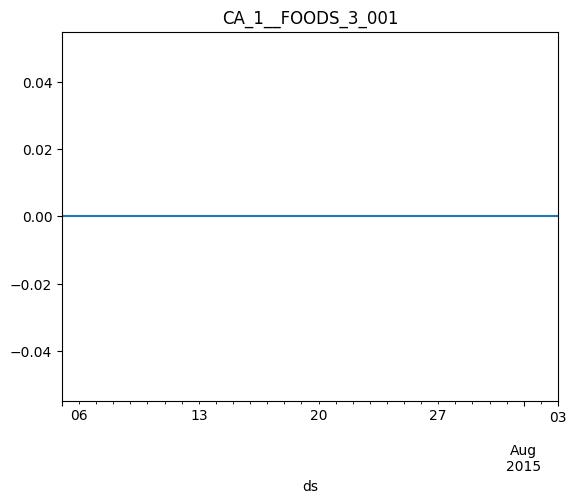

In [71]:
df_results.query("unique_id == 'CA_1__FOODS_3_001' and cutoff == '2015-07-04'").set_index('ds')['y'].plot(title='CA_1__FOODS_3_001')
plt.show()
# df_results.query("unique_id == 'CA_1__FOODS_3_445' and cutoff == '2015-09-02'").set_index('ds')['y'].plot(title='CA_1__FOODS_3_445')
# df_results.query("unique_id == 'CA_1__FOODS_3_427' and cutoff == '2015-12-01'").set_index('ds')['y'].plot(title='CA_1__FOODS_3_427')

In [73]:
get_top_k_results(df_metrics_item_cutoff, model_name="LGBMRegressor", group_index=["unique_id", "cutoff"], return_best=False)

,,LGBMRegressor
unique_id,cutoff,
CA_1__FOODS_3_379,2015-09-02,3.7380
CA_1__FOODS_3_147,2015-08-03,2.5453
CA_1__FOODS_3_315,2015-07-04,2.4738


# Visualizations
* prediction over time
* residual plots
* aggregation by- day, month
    * best/worst month
    * top k best/worst predictions

In [74]:
def plot_aggregated_series(df: pd.DataFrame, agg_index: str, agg_freq: str, models: list[str], alphas: list[float], linestyles: list[str]):
    fig, ax = plt.subplots(figsize=(10, 6), layout="tight")
    agg2freq = {"ds": "day", "cutoff": "month"}
    for model, alpha, linestyle in zip(models, alphas, linestyles):
        df.groupby(agg_index)[model].sum().plot(ax=ax, alpha=alpha, linestyle=linestyle)
    ax.set(title=f"Aggregated Series Over Time ({agg_freq})", ylabel="sales", xlabel="date")
    ax.legend()
    fig.autofmt_xdate()
    plt.show()

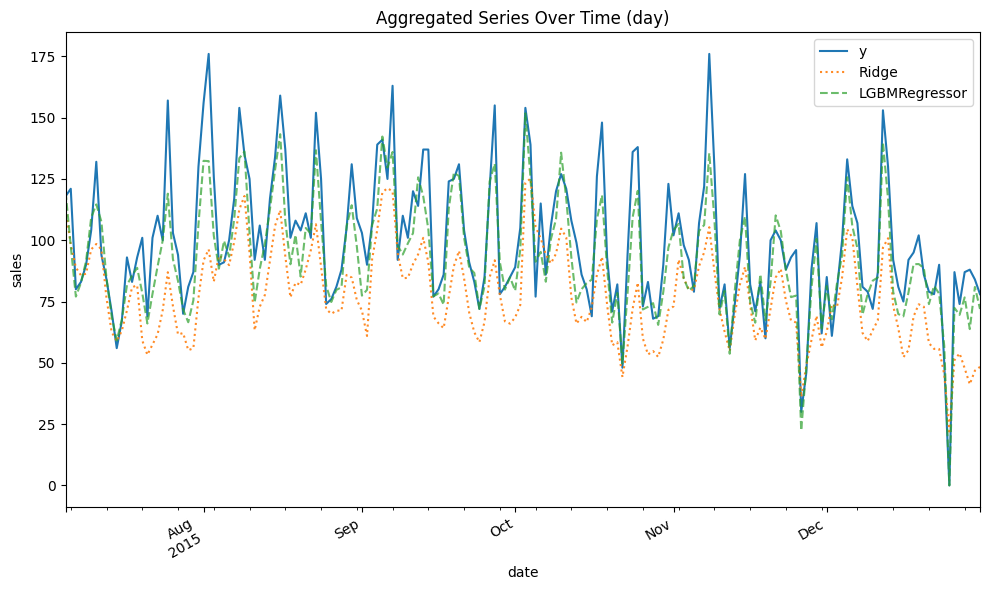

In [75]:
plot_aggregated_series(
    df=df_results,
    agg_index="ds",
    agg_freq="day",
    models=["y", "Ridge", "LGBMRegressor"],
    alphas=[1, 0.9, 0.7],
    linestyles=['-', ':', '--'],
)

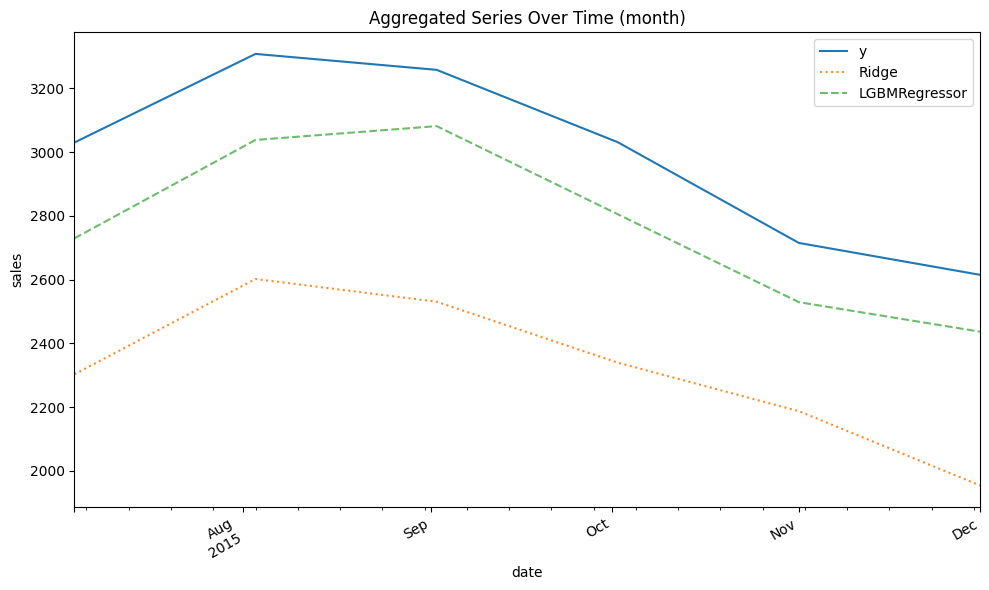

In [76]:
plot_aggregated_series(
    df=df_results,
    agg_index="cutoff",
    agg_freq="month",
    models=["y", "Ridge", "LGBMRegressor"],
    alphas=[1, 0.9, 0.7],
    linestyles=['-', ':', '--'],
)

In [77]:
def series_analysis_plots(
    df: pd.DataFrame,
    df_preds: pd.DataFrame,
    unique_id: str,
    model_col: str,
    date_col: str="ds",
    target_col: str="y",
    start_date: pd.Timestamp=pd.Timestamp("2012-01-01"),
    **plt_kwargs
):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=plt_kwargs.get("figsize", (12, 8)), layout="tight")
    df.query("(unique_id == @unique_id) and (ds >= @start_date)")[[date_col, target_col]].set_index(date_col).plot(ax=axes[0])
    axes[0].set(title="Series", xlabel="date", ylabel="sales")
    axes[0].tick_params(axis='x', rotation=plt_kwargs.get("rotation", 0))
    axes[0].legend().set_visible(False)
    df_preds.query("(unique_id == @unique_id)").set_index(date_col)[[target_col, model_col]].plot(ax=axes[1])
    axes[1].set(title="Actual vs. Prediction", xlabel="date", ylabel="sales")
    axes[1].tick_params(axis='x', rotation=plt_kwargs.get("rotation", 0))
    (
        df_preds
        .query("(unique_id == @unique_id)")
        .set_index(date_col)[[target_col, model_col]]
        .apply(lambda s: s[target_col] - s[model_col], axis=1)
        .plot(color="salmon", ax=axes[2]))
    axes[2].set(title="Residual Plot", xlabel="date", ylabel="sales")
    axes[2].tick_params(axis='x', rotation=plt_kwargs.get("rotation", 0))
    fig.suptitle(f"{unique_id}")
    plt.show()

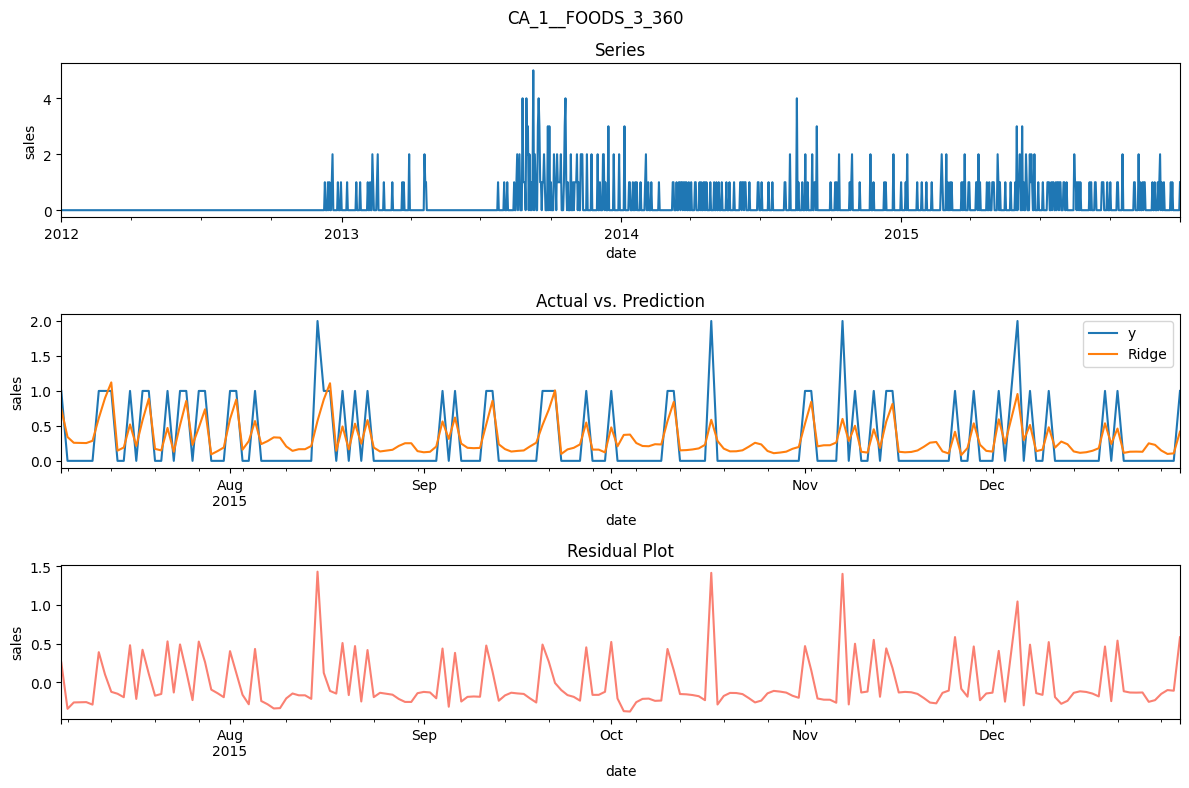

In [78]:
series_analysis_plots(df=df, df_preds=df_results, unique_id="CA_1__FOODS_3_360", model_col="Ridge")

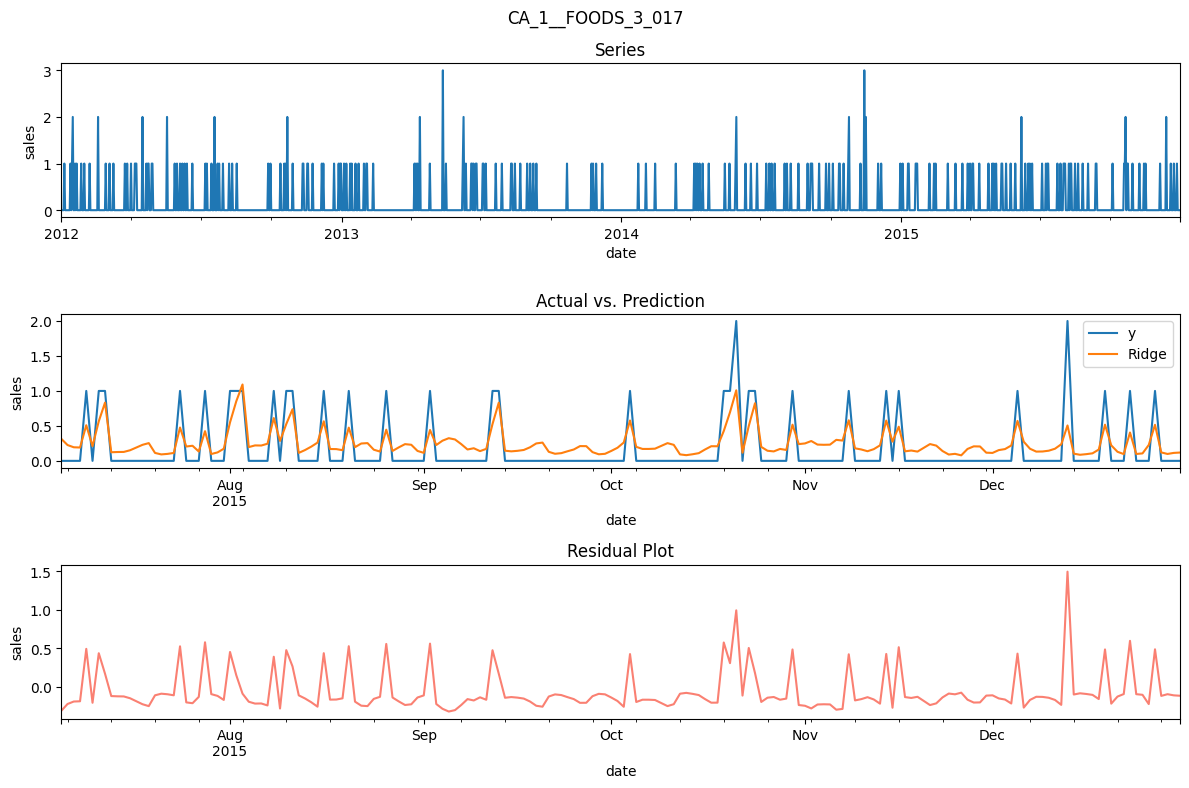

In [79]:
series_analysis_plots(df=df, df_preds=df_results, unique_id="CA_1__FOODS_3_017", model_col="Ridge")

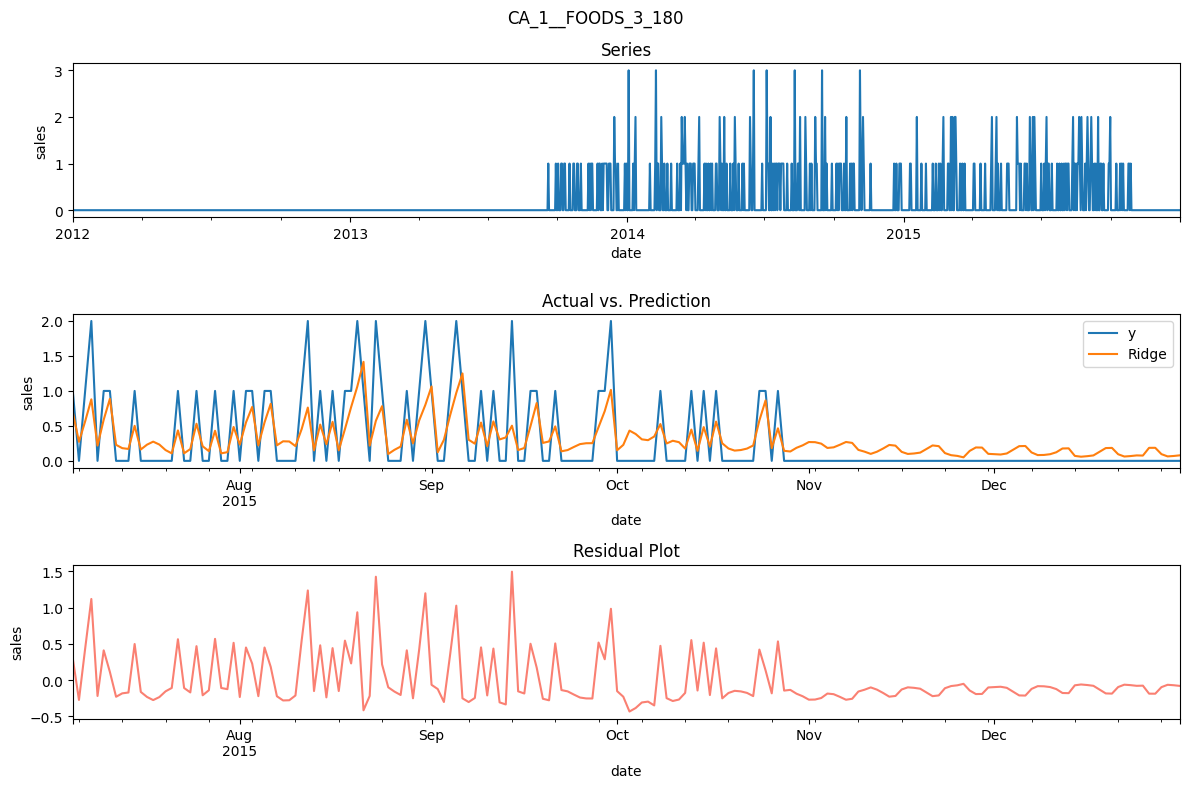

In [80]:
series_analysis_plots(df=df, df_preds=df_results, unique_id="CA_1__FOODS_3_180", model_col="Ridge")

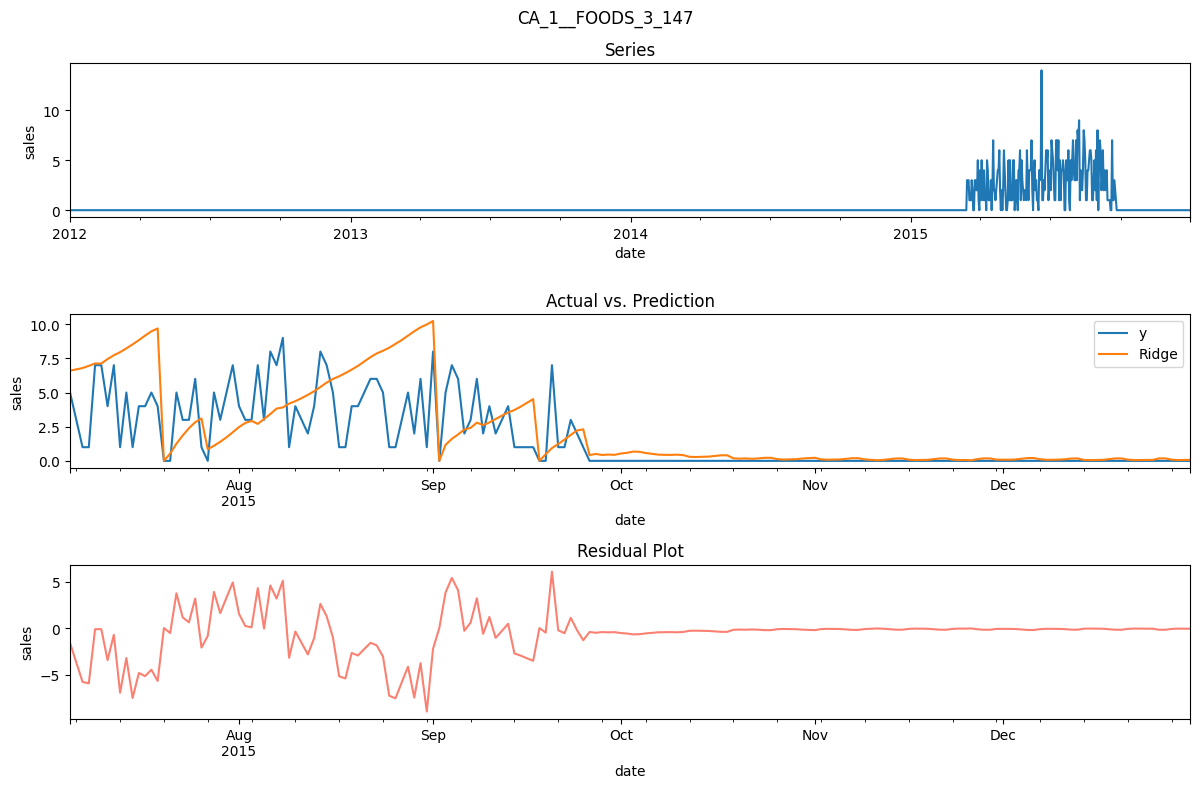

In [81]:
series_analysis_plots(df=df, df_preds=df_results, unique_id="CA_1__FOODS_3_147", model_col="Ridge")

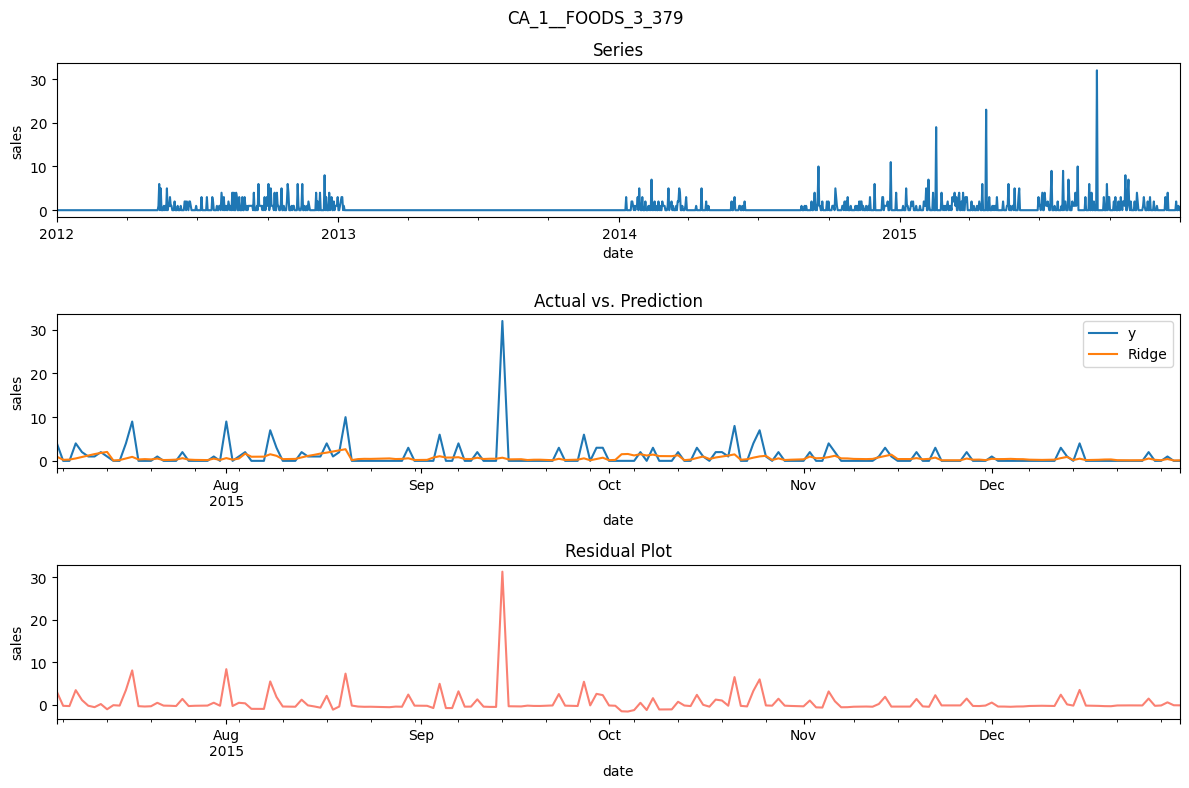

In [82]:
series_analysis_plots(df=df, df_preds=df_results, unique_id="CA_1__FOODS_3_379", model_col="Ridge")

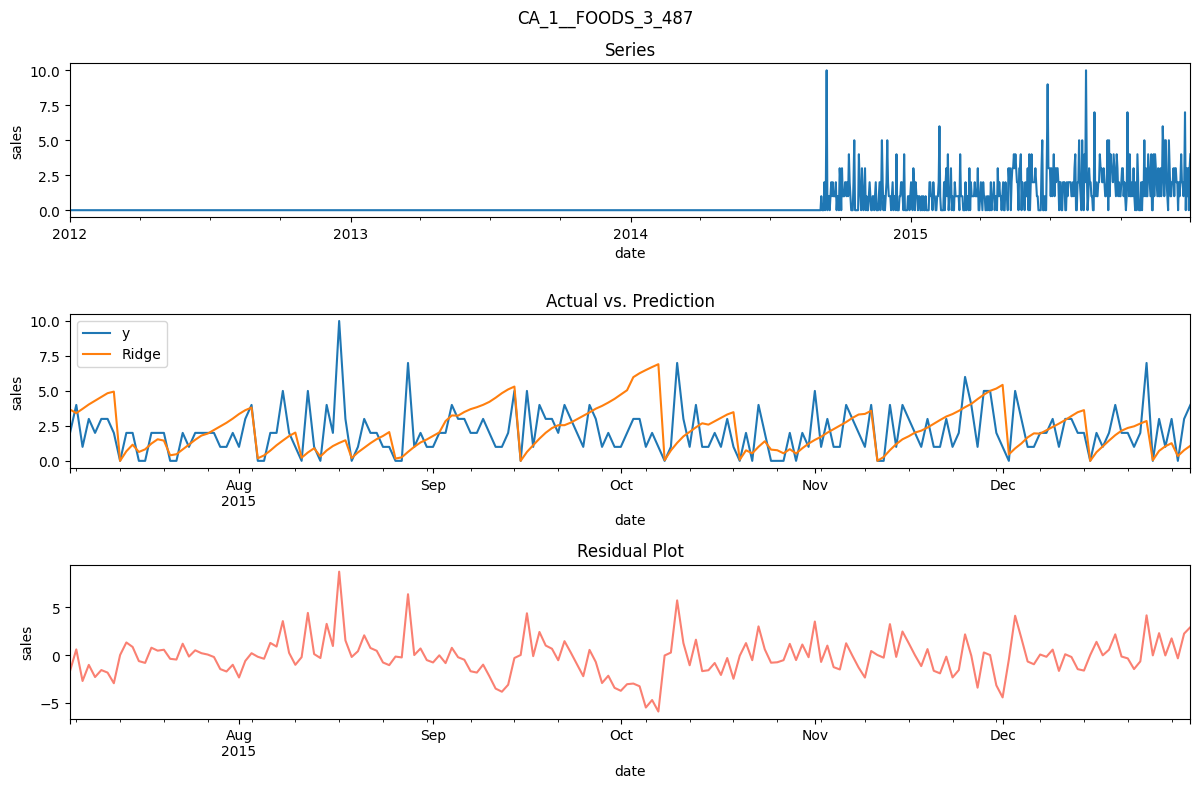

In [83]:
series_analysis_plots(df=df, df_preds=df_results, unique_id="CA_1__FOODS_3_487", model_col="Ridge")

## LGBMRegressor

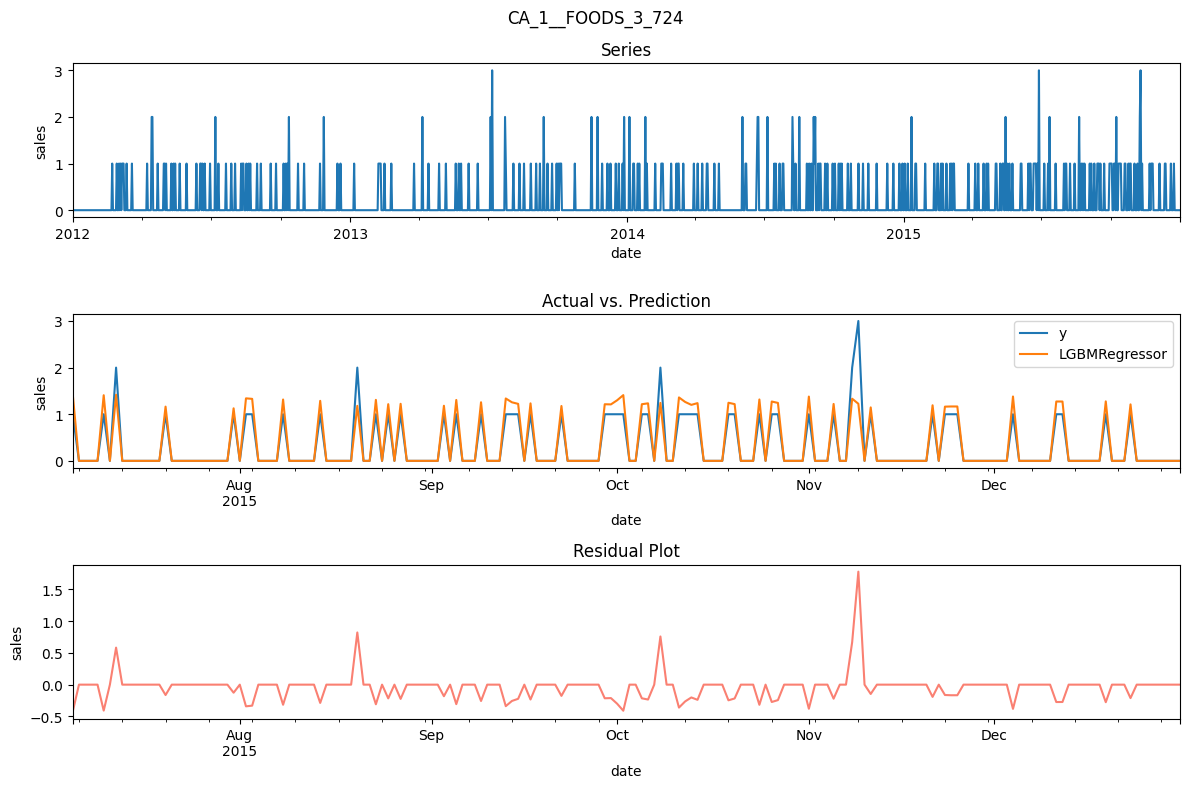

In [84]:
series_analysis_plots(df=df, df_preds=df_results, unique_id="CA_1__FOODS_3_724", model_col="LGBMRegressor")

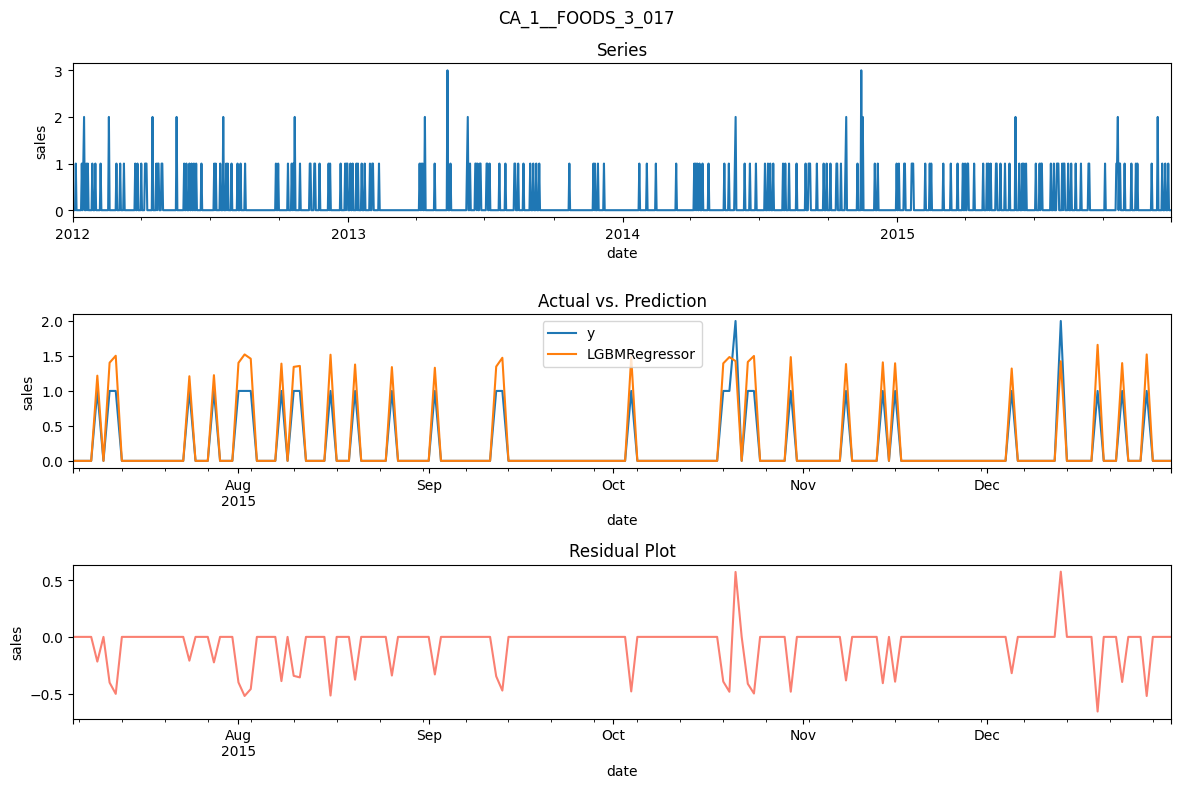

In [85]:
series_analysis_plots(df=df, df_preds=df_results, unique_id="CA_1__FOODS_3_017", model_col="LGBMRegressor")

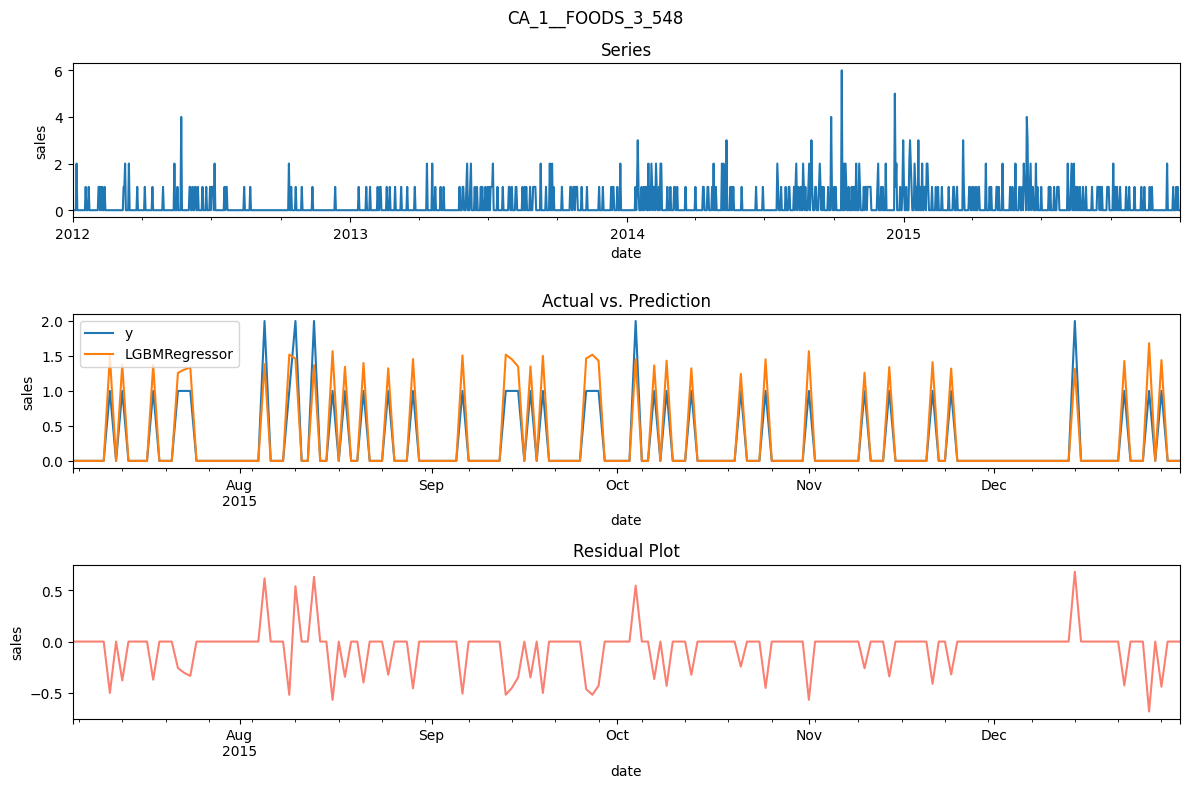

In [86]:
series_analysis_plots(df=df, df_preds=df_results, unique_id="CA_1__FOODS_3_548", model_col="LGBMRegressor")

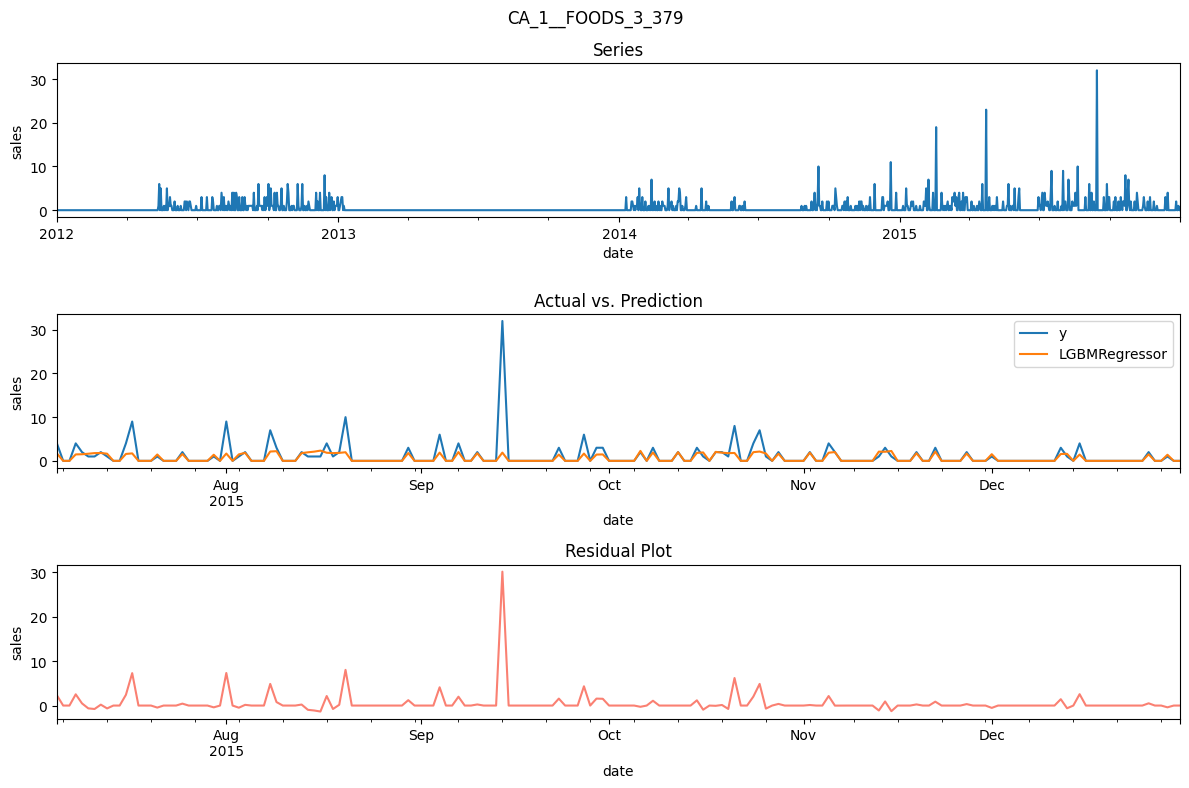

In [87]:
series_analysis_plots(df=df, df_preds=df_results, unique_id="CA_1__FOODS_3_379", model_col="LGBMRegressor")

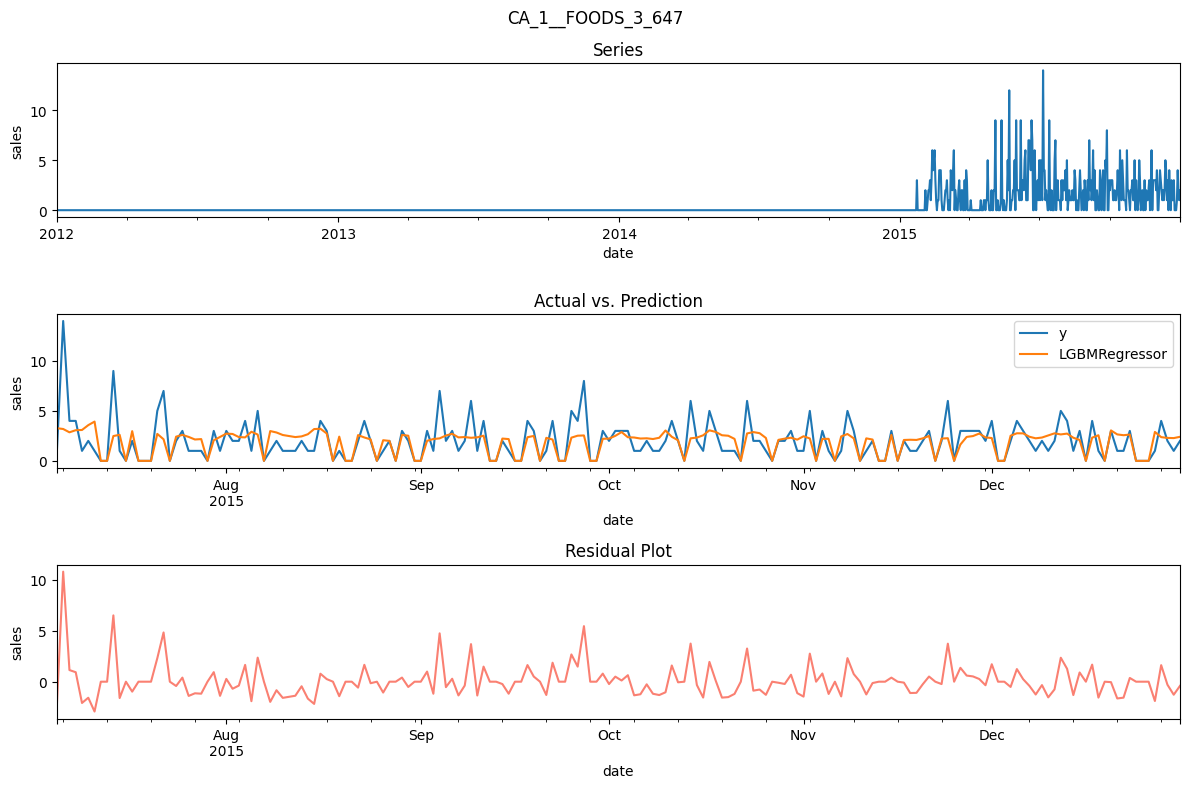

In [88]:
series_analysis_plots(df=df, df_preds=df_results, unique_id="CA_1__FOODS_3_647", model_col="LGBMRegressor")

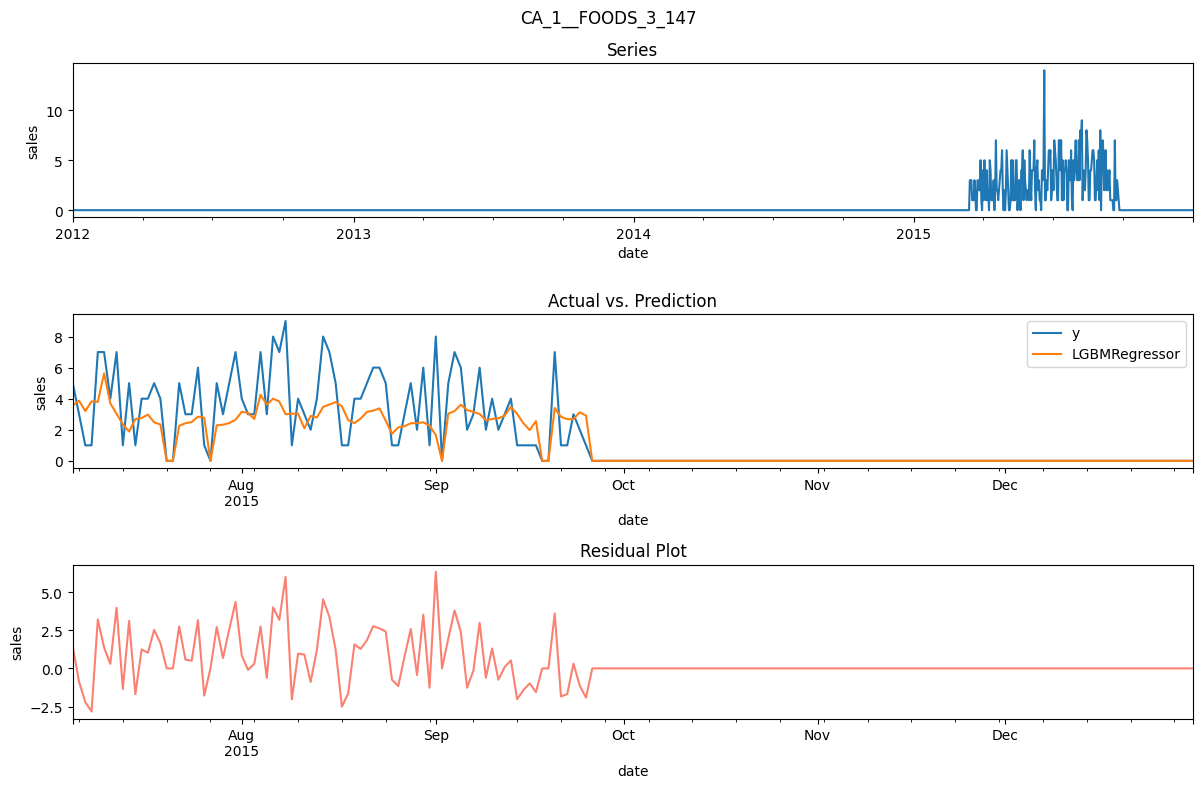

In [89]:
series_analysis_plots(df=df, df_preds=df_results, unique_id="CA_1__FOODS_3_147", model_col="LGBMRegressor")